In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler

### Ridge Model - Predicting Reports

In [146]:
hikes = pd.read_csv('../data/wta-parks-data.csv', sep='\t', index_col=0)
hikes_model = hikes.drop(columns=['description','url','name','pass: None','rating','votes', 'lat','lon']).dropna()

In [147]:
X = hikes_model.drop(columns=['reports']).values
y = hikes_model['reports'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)
columns = hikes_model.drop(columns=['reports']).columns

In [158]:
nalphas = 50
min_alpha_exp = 1
max_alpha_exp = 6
nfeatures = X.shape[1]
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
mse_train = np.zeros(nalphas)
mse_test = np.zeros(nalphas)
for idx, alpha in enumerate(alphas):
    model = Pipeline([('standardize', StandardScaler()),
                     ('ridge', RidgeCV(alphas=[alpha], cv=10))])
    model.fit(X_train, y_train)
    coefs[idx] = model.steps[1][1].coef_
    mse_train[idx] = mean_squared_error(y_train, model.predict(X_train))
    mse_test[idx] = mean_squared_error(y_test, model.predict(X_test))

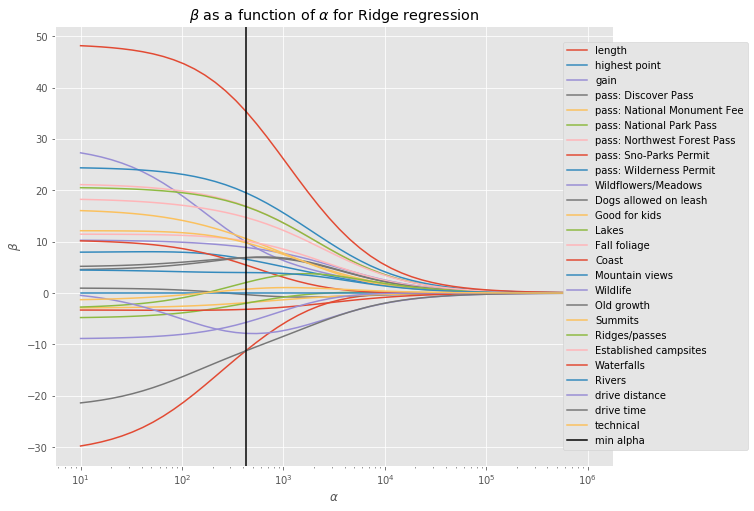

In [159]:
fig, ax = plt.subplots(figsize=(10,8.1))
for feature in range(nfeatures):
    ax.plot(alphas, coefs[:, feature],
             label=columns[feature])

ax.axvline(alphas[(np.argmin(mse_test))], label='min alpha', color='k')
ax.set_xscale('log')
ax.set_title("$\\beta$ as a function of $\\alpha$ for Ridge regression")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.legend(loc="right", bbox_to_anchor=(1.25, .5), framealpha=1)
fig.savefig('../images/ridge_beta_vs_alpha.png', bbox_inches='tight', dpi=350)

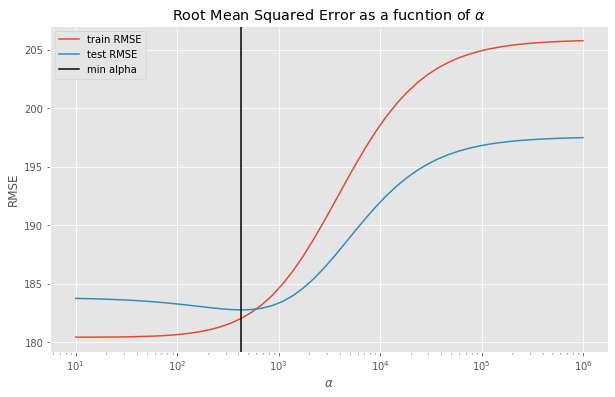

In [160]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(alphas, np.sqrt(mse_train), label='train RMSE')
ax.plot(alphas, np.sqrt(mse_test), label='test RMSE')
ax.axvline(alphas[(np.argmin(mse_test))], label='min alpha', color='k')
ax.set_xscale('log')
ax.set_title('Root Mean Squared Error as a fucntion of $\\alpha$')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("RMSE")
ax.legend(loc='best', framealpha=1)
fig.savefig('../images/ridge_rmse.png', bbox_inches='tight', dpi=350)

In [161]:
min_alpha = alphas[(np.argmin(mse_test))]
min_alpha

429.1934260128778

In [162]:
model = Pipeline([('standardize', StandardScaler()),
                     ('ridge', RidgeCV(alphas=[min_alpha], cv=10))])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridge',
                 RidgeCV(alphas=array([429.19342601]), cv=10,
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring=None, store_cv_values=False))],
         verbose=False)

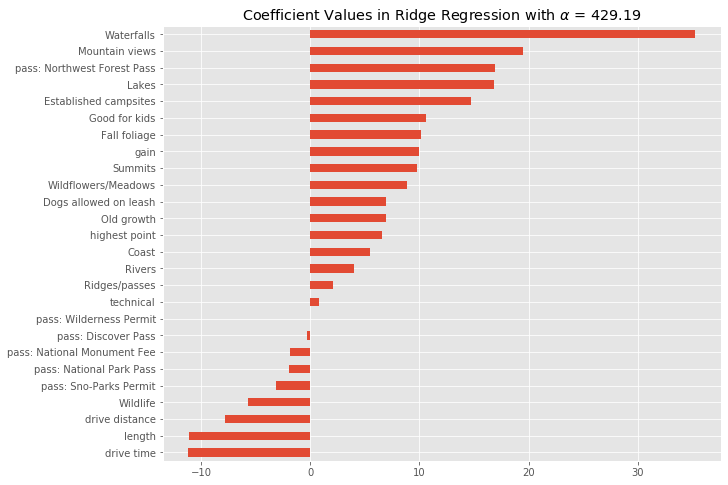

In [163]:
ridge_coefs = model.steps[1][1].coef_

ridge_coefs = pd.DataFrame({'Coefficients': model.steps[1][1].coef_}, 
                       index=hikes_model.drop(columns=['reports']).columns)

ridge_coefs = ridge_coefs.sort_values(by='Coefficients')
ridge_coefs.plot(kind='barh', figsize=(10,8), legend=False)
plt.title("Coefficient Values in Ridge Regression with $\\alpha$ = %.2f" % min_alpha)
plt.savefig("../images/ridge_coefs_bar.png", bbox_inches='tight', dpi=350)